# Backtesting a simple strategy on ETH

This time I want to use real data, not the testnet :)

## Download and prepare the data for backtesting

In [1]:
import pandas as pd
import numpy as np


I have encrypted my API login info, so I just load and use them without revealing anything :)

In [2]:
path1 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_secret.key"
path2 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_encrypted_keys.txt"

In [3]:
from pybit.unified_trading import HTTP
from encrypted.encryption import load_keys

api_key, api_secret = load_keys(path1, path2)
session = HTTP(
    testnet=False,
    api_key= api_key,
    api_secret = api_secret,
)

print(session.get_server_time())

{'retCode': 0, 'retMsg': 'OK', 'result': {'timeSecond': '1716698442', 'timeNano': '1716698442831447965'}, 'retExtInfo': {}, 'time': 1716698442831}


Now load ETH data

In [4]:
from utils.convert_datetime import convert_to_timestamp
start_date = convert_to_timestamp("2024-01-01")
end_date = convert_to_timestamp("2024-5-25")

In [5]:
def get_data_with_volume_bybit(session, symbol, start_date, end_date, interval = "D", category = "linear", limit = 200):
    
    data = session.get_kline(
    category=category,
    symbol=symbol,
    interval= interval,
    start = start_date,
    end = end_date,
    limit= limit,
    )


    # Convert list to DataFrame
    columns = ['startTime', 'openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover']
    df = pd.DataFrame(data["result"]['list'], columns=columns)

    # Adding a new column for the symbol
    df['symbol'] = symbol

    # Convert startTime to datetime and prices to floats
    df['startTime'] = pd.to_datetime(df['startTime'].astype(float), unit='ms')
    for col in ['openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover']:
        df[col] = df[col].astype(float)

    # Sort the DataFrame by startTime in descending order
    df = df.sort_values(by='startTime', ascending=False)
    
    print(df.head())
    
    return df


def get_data_OI_bybit(session, symbol, start_date, end_date, interval = "1d", category = "linear", limit = 200):
    
    data_OI = session.get_open_interest(
    category = category,
    symbol = symbol,
    intervalTime = interval,
    startTime = start_date,
    endTime = end_date,
    limit = limit,
    )


    # Convert list to DataFrame
    columns = ['openInterest', 'timestamp']
    df = pd.DataFrame(data_OI["result"]['list'], columns=columns)


    # Convert startTime to datetime and prices to floats
    df['startTime'] = pd.to_datetime(df['timestamp'].astype(float), unit='ms')
    df['openInterest'] = df['openInterest'].astype(float)
    # Sort the DataFrame by startTime in descending order
    df = df.sort_values(by='startTime', ascending=False)

    # Display the DataFrame
    print(df.head())
    return df

In [6]:
symbol = "ETHUSD"
df1 = get_data_with_volume_bybit(session, symbol, start_date, end_date, interval = "D", category = "linear", limit = 200)
df2 = get_data_OI_bybit(session, symbol, start_date, end_date, interval = "1d", category = "linear", limit = 200)

df_ETH = pd.merge(df1, df2[['startTime', 'openInterest']], on='startTime', how='inner')

df_ETH.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting.csv', index=False) 

   startTime  openPrice  highPrice  lowPrice  closePrice       volume  \
0 2024-05-24    3784.15    3832.05   3627.05     3728.60  268476729.0   
1 2024-05-23    3740.50    3951.15   3507.05     3784.15  998759848.0   
2 2024-05-22    3793.00    3815.35   3654.85     3740.50  287634099.0   
3 2024-05-21    3665.30    3844.85   3627.70     3793.00  375445948.0   
4 2024-05-20    3069.10    3699.90   3046.05     3665.30  439138274.0   

        turnover  symbol  
0   72224.501005  ETHUSD  
1  263611.939310  ETHUSD  
2   76947.502901  ETHUSD  
3  100420.642724  ETHUSD  
4  130692.238330  ETHUSD  
   openInterest      timestamp  startTime
0   338357319.0  1716508800000 2024-05-24
1   349971866.0  1716422400000 2024-05-23
2   348212671.0  1716336000000 2024-05-22
3   342281637.0  1716249600000 2024-05-21
4   315706080.0  1716163200000 2024-05-20


In [7]:
df_ETH.head()

,startTime,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol,openInterest
0,2024-05-24,3784.15,3832.05,3627.05,3728.60,268476729.0,72224.501005,ETHUSD,338357319.0
1,2024-05-23,3740.50,3951.15,3507.05,3784.15,998759848.0,263611.939310,ETHUSD,349971866.0
2,2024-05-22,3793.00,3815.35,3654.85,3740.50,287634099.0,76947.502901,ETHUSD,348212671.0
3,2024-05-21,3665.30,3844.85,3627.70,3793.00,375445948.0,100420.642724,ETHUSD,342281637.0
4,2024-05-20,3069.10,3699.90,3046.05,3665.30,439138274.0,130692.238330,ETHUSD,315706080.0


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

def visualize_df_with_vol_oi(df, saving_path):
    # Prepare data for candlestick chart
    df['date'] = mdates.date2num(df['startTime'])
    ohlc = df[['date', 'openPrice', 'highPrice', 'lowPrice', 'closePrice']].copy()
    volume = df[['date', 'volume']].copy()
    open_interest = df[['date', 'openInterest']].copy()

    # Creating subplots with shared x-axis
    fig, (ax, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1, 1]})

    # Plot candlestick chart
    candlestick_ohlc(ax, ohlc.values, width=0.5, colorup='green', colordown='red', alpha=1)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('Price')

    # Plot volume below candlestick chart
    ax2.bar(volume['date'], volume['volume'], color='blue', width=0.5)
    ax2.set_ylabel('Volume')

    # Plot open interest below volume chart
    ax3.bar(open_interest['date'], open_interest['openInterest'], color='gray', width=0.5)
    ax3.set_ylabel('Open Interest')

    # Formatting the shared x-axis
    plt.xticks(rotation=45)
    plt.subplots_adjust(hspace=0)  # Reduce space between plots

    # Set the title for the entire figure
    fig.suptitle(f"Candlestick Chart for {df['symbol'][0]}", fontsize=16)
    
    fig.savefig(saving_path)

    # Display the plot
    plt.show()

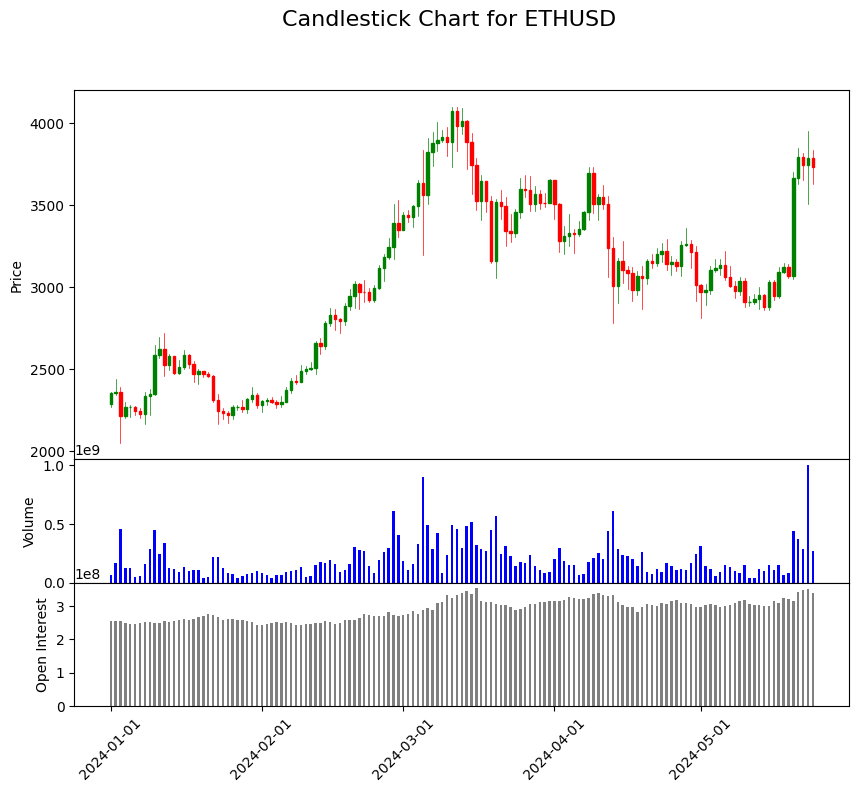

In [9]:
visualize_df_with_vol_oi(df_ETH, saving_path = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/some_plots/ETH_chart.png")

# Startegies with Backtrader

In [1]:
import backtrader as bt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter

Let's define a class for the trading strategy to use

setup backtest

Since I am using a personal csv dataset, I need to make sure that backtrader reads every column and is able to to use them as data_feeds

## ETH dataset

In [6]:
# Read CSV data into a Pandas DataFrame
data = pd.read_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting.csv", parse_dates=True)
data = data.rename(columns = {'startTime':'datetime'})
# Assuming your DataFrame is called 'data'
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'startTime' column as the index
data.set_index('datetime', inplace=True)
data.to_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting_BT.csv")

In [16]:
data = pd.read_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting.csv", parse_dates=True, index_col="datetime")

data.drop(columns=["Unnamed: 0"], inplace=True)
data.to_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting.csv")
data.head()

,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol,openInterest
datetime,,,,,,,,
2024-05-24,3784.15,3832.05,3627.05,3728.60,268476729.0,72224.501005,ETHUSD,338357319.0
2024-05-23,3740.50,3951.15,3507.05,3784.15,998759848.0,263611.939310,ETHUSD,349971866.0
2024-05-22,3793.00,3815.35,3654.85,3740.50,287634099.0,76947.502901,ETHUSD,348212671.0
2024-05-21,3665.30,3844.85,3627.70,3793.00,375445948.0,100420.642724,ETHUSD,342281637.0
2024-05-20,3069.10,3699.90,3046.05,3665.30,439138274.0,130692.238330,ETHUSD,315706080.0


I discovered that if you put the wrong order of dates (older to recent) your strategy won't run.

In [9]:
# Invert the rows of the DataFrame
df_inverted = data.iloc[::-1]
df_inverted.to_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting_IV.csv")
df_inverted.head()

,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol,openInterest
datetime,,,,,,,,
2024-01-01,2283.25,2355.75,2266.45,2355.55,67534313.0,29171.822967,ETHUSD,254830192.0
2024-01-02,2355.55,2437.45,2341.85,2357.20,164669468.0,69117.913195,ETHUSD,255828644.0
2024-01-03,2357.20,2388.25,2050.10,2210.45,455482422.0,206336.113269,ETHUSD,256142608.0
2024-01-04,2210.45,2297.60,2202.15,2268.75,128595490.0,57082.858019,ETHUSD,249286756.0
2024-01-05,2268.75,2278.50,2206.00,2269.50,122346801.0,54556.493067,ETHUSD,245732972.0


## Two ways of creating a data feed

In [2]:
data = pd.read_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting_IV.csv", parse_dates=True, index_col="datetime")
# Ensure the 'startTime' column is set as the index and convert column names to lowercase
# Define the custom data feed class
class PandasData(bt.feeds.PandasData):
    # Add a 'volume', 'openInterest', and 'turnover' lines to the inherited ones from the base class
    lines = ('volume', 'openinterest', 'turnover')
    
    # Define parameters for the column names
    params = (
        ('datetime', None),
        ('open', 'openPrice'),
        ('high', 'highPrice'),
        ('low', 'lowPrice'),
        ('close', 'closePrice'),
        ('volume', 'volume'),
        ('openinterest', 'openInterest'),
        ('turnover', 'turnover'),
    )

# Create an instance of the custom data feed
data_feed_1 = PandasData(dataname=data) #, fromdate=datetime(2024, 1, 1), todate=datetime(2024, 5, 24))

In [3]:
import backtrader.feeds as btfeeds

data_feed_2 = btfeeds.GenericCSVData(
    dataname="/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting_IV.csv",
    #fromdate=datetime(2024, 1, 1), 
    #todate=datetime(2024, 5, 24),
    nullvalue=0.0,
    dtformat=('%Y-%m-%d'),
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    openinterest=8
)


## Simple first example of strategy

In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [5]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Using 1st data_feed showcase

In [6]:
cerebro = bt.Cerebro(stdstats = False)
# Add a strategy
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed_1)
cerebro.broker.setcash(10000.0)


#cerebro.run()
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 10000.00
2024-01-01, Close, 2355.55
2024-01-01, BUY CREATE, 2355.55
2024-01-02, BUY EXECUTED, 2355.55
2024-01-02, Close, 2357.20
2024-01-03, Close, 2210.45
2024-01-04, Close, 2268.75
2024-01-05, Close, 2269.50
2024-01-06, Close, 2240.15
2024-01-07, Close, 2221.80
2024-01-07, SELL CREATE, 2221.80
2024-01-08, SELL EXECUTED, 2221.80
2024-01-08, Close, 2331.50
2024-01-09, Close, 2343.70
2024-01-10, Close, 2584.85
2024-01-11, Close, 2619.80
2024-01-12, Close, 2521.15
2024-01-13, Close, 2577.45
2024-01-14, Close, 2472.60
2024-01-15, Close, 2510.60
2024-01-16, Close, 2586.05
2024-01-17, Close, 2528.30
2024-01-18, Close, 2468.80
2024-01-18, BUY CREATE, 2468.80
2024-01-19, BUY EXECUTED, 2468.80
2024-01-19, Close, 2489.15
2024-01-20, Close, 2469.20
2024-01-21, Close, 2454.80
2024-01-22, Close, 2311.30
2024-01-23, Close, 2241.15
2024-01-24, Close, 2233.00
2024-01-24, SELL CREATE, 2233.00
2024-01-25, SELL EXECUTED, 2233.00
2024-01-25, Close, 2216.00
2024-01-25, BUY CREATE

Using 2nd data_feed showcase

In [7]:
cerebro = bt.Cerebro(stdstats = False)
# Add a strategy
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed_2)
#cerebro.addobserver(bt.observers.BuySell)
#cerebro.addobserver(bt.observers.Value)
cerebro.broker.setcash(10000.0)


#cerebro.run()
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 10000.00
2024-01-01, Close, 2355.55
2024-01-01, BUY CREATE, 2355.55
2024-01-02, BUY EXECUTED, 2355.55
2024-01-02, Close, 2357.20
2024-01-03, Close, 2210.45
2024-01-04, Close, 2268.75
2024-01-05, Close, 2269.50
2024-01-06, Close, 2240.15
2024-01-07, Close, 2221.80
2024-01-07, SELL CREATE, 2221.80
2024-01-08, SELL EXECUTED, 2221.80
2024-01-08, Close, 2331.50
2024-01-09, Close, 2343.70
2024-01-10, Close, 2584.85
2024-01-11, Close, 2619.80
2024-01-12, Close, 2521.15
2024-01-13, Close, 2577.45
2024-01-14, Close, 2472.60
2024-01-15, Close, 2510.60
2024-01-16, Close, 2586.05
2024-01-17, Close, 2528.30
2024-01-18, Close, 2468.80
2024-01-18, BUY CREATE, 2468.80
2024-01-19, BUY EXECUTED, 2468.80
2024-01-19, Close, 2489.15
2024-01-20, Close, 2469.20
2024-01-21, Close, 2454.80
2024-01-22, Close, 2311.30
2024-01-23, Close, 2241.15
2024-01-24, Close, 2233.00
2024-01-24, SELL CREATE, 2233.00
2024-01-25, SELL EXECUTED, 2233.00
2024-01-25, Close, 2216.00
2024-01-25, BUY CREATE